In [1]:
#library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import math
%matplotlib inline

In [2]:
#loading data
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [5]:
#creating validation data and scaling data to range 0-1
X_valid, X_train = X_train[:5000] / 255., X_train[5000:] / 255.
y_valid, y_train = y_train[:5000], y_train[5000:]
X_test = X_test / 255.

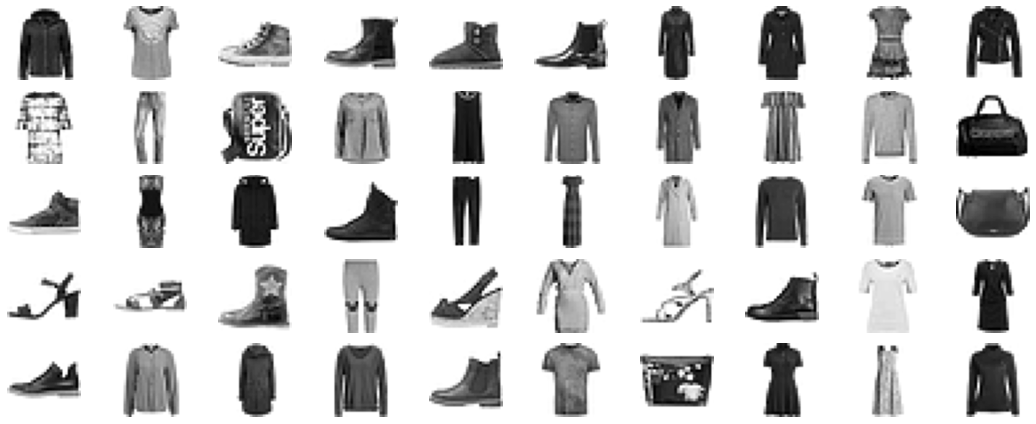

In [6]:
plt.figure(figsize=(15, 6))
n_rows = 5
n_cols = 10

for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_train[i], cmap='binary')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [7]:
y_train[:50]

array([4, 0, 7, 9, 9, 9, 4, 4, 3, 4, 0, 1, 8, 6, 3, 6, 4, 3, 2, 8, 7, 3,
       4, 7, 1, 3, 4, 2, 0, 8, 5, 5, 9, 1, 5, 3, 5, 9, 0, 3, 9, 6, 4, 2,
       9, 0, 8, 3, 3, 2], dtype=uint8)

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
class_names[y_train[0]]

'Coat'

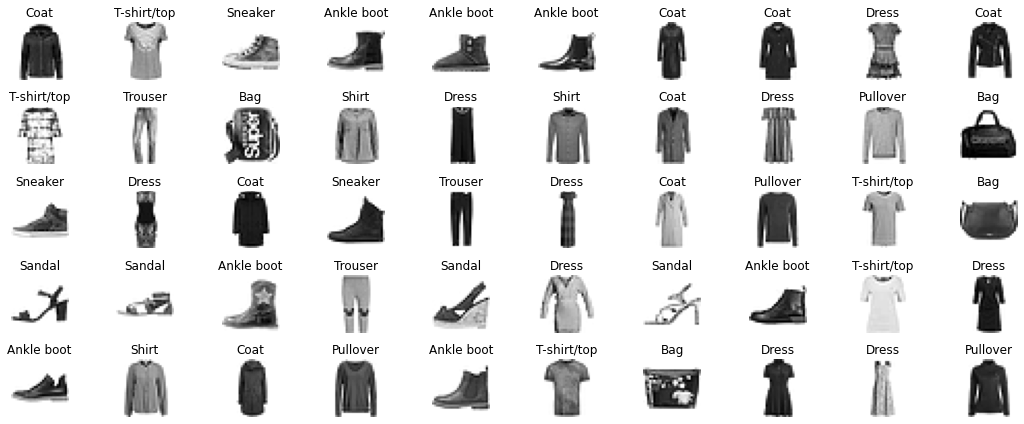

In [10]:
plt.figure(figsize=(15, 6))
n_rows = 5
n_cols = 10

for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_train[i], cmap='binary')
    plt.axis('off')
    plt.title(class_names[y_train[i]], fontdict={'fontsize': 12, 'color': 'black'})
    
plt.tight_layout()
plt.show()

In [11]:
#scale inputs to mean 0 and standard deviation 1
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [12]:
###Build an ANN with 20 hidden layers of 100 neurons each:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='elu', 
                                 kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [15]:
##Build an ANN with 20 hidden layers of 100 neurons each:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [16]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')

1719/1719 [==============================] - 15s 7ms/step - loss: 171360531399.6992 - accuracy: 0.4388


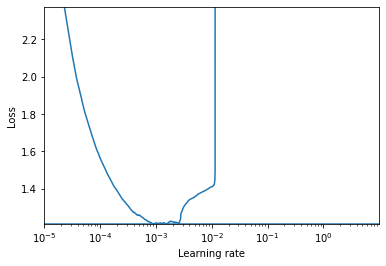

In [17]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [18]:
rates[np.argmin(losses)]

0.0009080348

We will set the learning rate slightly lower (learning_rate=0.0008), create the callbacks we need and train the model:

In [19]:
optimizer = keras.optimizers.Nadam(learning_rate=8e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_fashion_mnist_model_v1.h5', 
                                                      save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [21]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
          callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 16s 7ms/step - loss: 0.8271 - accuracy: 0.7051 - val_loss: 0.4786 - val_accuracy: 0.8354
Epoch 2/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4731 - accuracy: 0.8333 - val_loss: 0.4140 - val_accuracy: 0.8594
Epoch 3/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4259 - accuracy: 0.8513 - val_loss: 0.4241 - val_accuracy: 0.8366
Epoch 4/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4063 - accuracy: 0.8568 - val_loss: 0.4508 - val_accuracy: 0.8506
Epoch 5/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3935 - accuracy: 0.8656 - val_loss: 0.3821 - val_accuracy: 0.8678
Epoch 6/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3772 - accuracy: 0.8709 - val_loss: 0.3958 - val_accuracy: 0.8706
Epoch 7/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3682 - accuracy: 0.8744 - val_loss: 0.3783 -

In [22]:
model = keras.models.load_model('my_fashion_mnist_model_v1.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 2ms/step - loss: 0.3225 - accuracy: 0.8888


[0.322464257478714, 0.8888000249862671]

We will try adding Batch Normalization and changing the learning rate:

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [26]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

1719/1719 [==============================] - 31s 12ms/step - loss: 10.7020 - accuracy: 0.4469


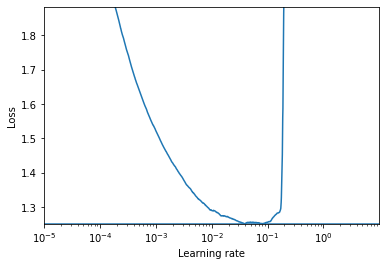

In [27]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [28]:
rates[np.argmin(losses)]

0.040000986

We will set the learning rate slightly lower (learning_rate=0.03), create the callbacks we need and train the model:

In [29]:
optimizer = keras.optimizers.Nadam(learning_rate=0.03)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [30]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_fashion_mnist_model_v2.h5', 
                                                      save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [31]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
          callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 32s 13ms/step - loss: 1.2084 - accuracy: 0.5510 - val_loss: 1.7794 - val_accuracy: 0.5670
Epoch 2/100
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6591 - accuracy: 0.7740 - val_loss: 2.2732 - val_accuracy: 0.4350
Epoch 3/100
1719/1719 [==============================] - 21s 12ms/step - loss: 0.5474 - accuracy: 0.8121 - val_loss: 4.2935 - val_accuracy: 0.3964
Epoch 4/100
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4738 - accuracy: 0.8356 - val_loss: 2.7684 - val_accuracy: 0.5380
Epoch 5/100
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4446 - accuracy: 0.8458 - val_loss: 2.5623 - val_accuracy: 0.4002
Epoch 6/100
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4028 - accuracy: 0.8599 - val_loss: 1.5690 - val_accuracy: 0.5680
Epoch 7/100
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3908 - accuracy: 0.8639 - val_loss: 0

In [32]:
model = keras.models.load_model('my_fashion_mnist_model_v2.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 0.3187 - accuracy: 0.8894


[0.3187134861946106, 0.8894000053405762]

The accuracy has slightly improved from 88.88% to 88.94% using this model.

We will try replacing Batch Normalizaion with SELU, and making necessary adjustments to ensure the network self-normalizes:

In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu', 
                                 kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [36]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

1719/1719 [==============================] - 15s 7ms/step - loss: 37554017.6150 - accuracy: 0.4610


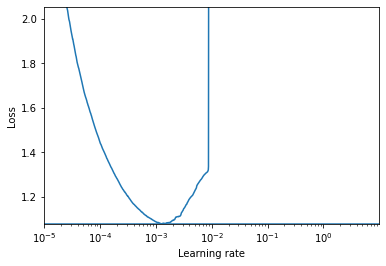

In [37]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [38]:
rates[np.argmin(losses)]

0.0012828882

We will set the learning rate slightly lower (learning_rate=0.001), create the callbacks we need and train the model:

In [39]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_fashion_mnist_model_v3.h5', 
                                                      save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [40]:
model.fit(X_train_scaled, y_train, epochs=100, 
          validation_data=(X_valid_scaled, y_valid), 
          callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7975 - accuracy: 0.7104 - val_loss: 0.6653 - val_accuracy: 0.7598
Epoch 2/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6496 - accuracy: 0.7586 - val_loss: 0.6252 - val_accuracy: 0.7826
Epoch 3/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6054 - accuracy: 0.7780 - val_loss: 0.5949 - val_accuracy: 0.7846
Epoch 4/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5731 - accuracy: 0.7907 - val_loss: 0.5876 - val_accuracy: 0.7918
Epoch 5/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5455 - accuracy: 0.7985 - val_loss: 0.5621 - val_accuracy: 0.7998
Epoch 6/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5154 - accuracy: 0.8097 - val_loss: 0.5232 - val_accuracy: 0.8140
Epoch 7/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4952 - accuracy: 0.8169 - val_loss: 0.5258 -

In [41]:
model = keras.models.load_model('my_fashion_mnist_model_v3.h5')
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 2ms/step - loss: 0.3618 - accuracy: 0.8802


[0.3618311583995819, 0.8802000284194946]

The accuracy did not improve, the best model so far is still the one with Batch Normalization.

We will try regularizing the model with alpha dropout:

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu', 
                                 kernel_initializer='lecun_normal'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [45]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

1719/1719 [==============================] - 16s 7ms/step - loss: 1810386.8574 - accuracy: 0.4353


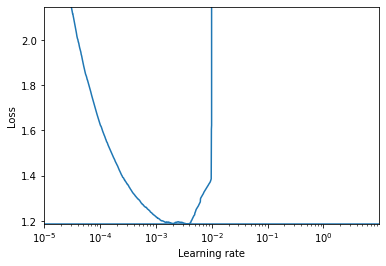

In [46]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [47]:
rates[np.argmin(losses)]

0.0035888655

We will set the learning rate slightly lower (learning_rate=0.002), create the callbacks we need and train the model:

In [48]:
optimizer = keras.optimizers.Nadam(learning_rate=0.002)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [49]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_fashion_mnist_model_v4.h5', 
                                                      save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [50]:
model.fit(X_train_scaled, y_train, epochs=100, 
          validation_data=(X_valid_scaled, y_valid), 
          callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 16s 7ms/step - loss: 1.1011 - accuracy: 0.6304 - val_loss: 0.7293 - val_accuracy: 0.7754
Epoch 2/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9958 - accuracy: 0.6398 - val_loss: 0.8995 - val_accuracy: 0.6262
Epoch 3/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9141 - accuracy: 0.6221 - val_loss: 0.7600 - val_accuracy: 0.7166
Epoch 4/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7259 - accuracy: 0.7407 - val_loss: 0.6311 - val_accuracy: 0.7802
Epoch 5/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7614 - accuracy: 0.7219 - val_loss: 0.7622 - val_accuracy: 0.7312
Epoch 6/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7084 - accuracy: 0.7427 - val_loss: 0.6196 - val_accuracy: 0.8088
Epoch 7/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6267 - accuracy: 0.7817 - val_loss: 0.6341 -

In [51]:
model = keras.models.load_model('my_fashion_mnist_model_v4.h5')
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 2ms/step - loss: 0.6196 - accuracy: 0.8088


[0.619559645652771, 0.8087999820709229]

The accuracy is actually worse using alpha dropout. We could try different thresholds of alpha dropout but we will move on for now.

We will retrain the model using 1cycle scheduling and see if it improves the model accuracy:

In [52]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [53]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu', 
                                 kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [55]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

430/430 [==============================] - 9s 15ms/step - loss: 751079575.4462 - accuracy: 0.3704


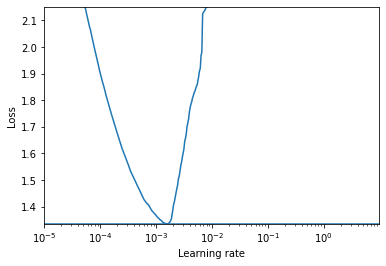

In [56]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [57]:
rates[np.argmin(losses)]

0.0016019635

We will set the max learning rate slightly lower (learning_rate=0.001) and train the model. The code below implements 1cycle scheduling:

In [58]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, 
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
        
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [59]:
n_epochs = 50
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.001)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size, 
                    validation_data=(X_valid_scaled, y_valid), callbacks=[onecycle])

Epoch 1/50
430/430 [==============================] - 7s 16ms/step - loss: 1.2432 - accuracy: 0.5649 - val_loss: 0.8939 - val_accuracy: 0.6920
Epoch 2/50
430/430 [==============================] - 6s 15ms/step - loss: 0.8037 - accuracy: 0.7085 - val_loss: 0.7309 - val_accuracy: 0.7400
Epoch 3/50
430/430 [==============================] - 7s 16ms/step - loss: 0.6849 - accuracy: 0.7505 - val_loss: 0.6575 - val_accuracy: 0.7688
Epoch 4/50
430/430 [==============================] - 6s 15ms/step - loss: 0.6119 - accuracy: 0.7773 - val_loss: 0.6006 - val_accuracy: 0.7860
Epoch 5/50
430/430 [==============================] - 6s 15ms/step - loss: 0.5609 - accuracy: 0.7950 - val_loss: 0.5663 - val_accuracy: 0.8000
Epoch 6/50
430/430 [==============================] - 6s 15ms/step - loss: 0.5230 - accuracy: 0.8084 - val_loss: 0.5390 - val_accuracy: 0.8036
Epoch 7/50
430/430 [==============================] - 6s 14ms/step - loss: 0.4930 - accuracy: 0.8194 - val_loss: 0.5166 - val_accuracy: 0.8134

In [60]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.0540 - accuracy: 0.9856


[0.054035648703575134, 0.9855636358261108]

In [61]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.8504


[0.6556959748268127, 0.8503999710083008]

The model overfits the training data because the accuracy for the training and validation data differs quite a lot. Hence, we will use the model with Batch Normalization for predictions:

In [62]:
model = keras.models.load_model('my_fashion_mnist_model_v2.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 0.3187 - accuracy: 0.8894


[0.3187134861946106, 0.8894000053405762]

In [63]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3572 - accuracy: 0.8842


[0.35720521211624146, 0.8841999769210815]